<a href="https://colab.research.google.com/github/Wappik/Duma_SMPR_TPWM/blob/main/Duma_SMPR_TPWM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Метод парзеновского окна**

---

Основное отличие метода парзеновского окна от метода ближайших соседей заключается в том, что весовую функцию мы рассматриваем не как ранговую, а как функцию расстояния.

Функция веса в таком случае выглядит следующим образом:

*w(i, z) = K(p(z, xi)/h)* 

Где i - номер объекта выборки, z - классифицируемый объект, xi - i-й объект выборки, h - ширина окна, K - функция ядра.

Функция ядра - произвольная чётная функция, невозрастающая на [0, +inf). На практике применяются следующие функции ядра:

1.   *K(r) = (3/4)(1-r^2)[|r| <= 1]* - Ядро Епанечникова (E)
2.   *K(r) = (15/16)(1-r^2)^2 [|r| <= 1]* -  Квартическое ядро (Q)
3.   *K(r) = (1-|r|)[|r| <= 1]* - Треугольное ядро (T)
4.   *K(r) = (2pi)^(-0.5) exp(-0.5r^2)* - Гауссовское ядро (G)
5.   *K(r) = 0.5[|r| <= 1]* - Прямоугольное ядро (P)

где: *r = p(z, xi)/h*

---
### ***Реализация***
---


In [ ]:
import numpy as np
from sklearn import datasets
import matplotlib.pyplot as plt
import math


def euclide(point1, point2):
    return ((point1[0] - point2[0]) ** 2 + (point1[1] - point2[1]) ** 2) ** (0.5)

def coreType(r, s):
    if s == 'E': return E_core(r)
    elif s == 'Q': return Q_core(r)
    elif s == 'T': return T_core(r)
    elif s == 'G': return G_core(r)
    elif s == 'P': return P_core(r)


def E_core(r): return (3 / 4) * (1 - r ** 2) * (abs(r) <= 1)
def Q_core(r): return (15 / 16) * ((1 - r ** 2) ** 2) * (abs(r) <= 1)
def T_core(r): return (1 - abs(r))*(abs(r) <= 1)
def G_core(r): return (2 * math.pi) ** (-0.5) * math.exp(-0.5 * (r ** 2))
def P_core(r): return 0.5 * (abs(r) <= 1)


def parzen(point, data, target, h, s):
    distances = []
    for d in data:
        distances.append(euclide(point, d))
    res = list(zip(distances, target))
    sorted_by_distances = sorted(res, key=lambda dist: dist[0])

    class_weights = [0, 0, 0]

    for i in range(1, len(sorted_by_distances)):
        class_number = sorted_by_distances[i - 1][1]
        r = sorted_by_distances[i - 1][0] / h
        core = abs(coreType(r, s))
        class_weights[class_number] += core

    if np.amax(class_weights) != 0:
        result_class = np.argmax(class_weights)
        return result_class
    else:
        return 3


def LOO(data, target, s):
    sum_errors = []

    for h in range(1, 21, 1):
        # h от 0.1 до 2.0
        h_norm = h / 10
        errors = []
        for i in range(150):
            error = 0
            dataCopy = list(data)
            objectData = dataCopy[i]
            dataCopy.pop(i)

            if parzen(objectData, dataCopy, target, h_norm, s) != target[i]:
                error += 1
            errors.append(error)
        sum_errors.append((sum(errors) - 1) / 150)
        errors.clear()
    return sum_errors


def drawPoints(point, data, target, targetPoint, errors, h, h_ind, s):
    cl = np.array(['red', 'green', 'blue', 'white'])
    fig = plt.figure(figsize=(18, 8))
    ax_1 = fig.add_subplot(1, 2, 1)
    ax_2 = fig.add_subplot(1, 2, 2)
    window = range(1, len(errors) + 1)
    window = [w / 10 for w in window]
    n_neighbors = np.array(window)

    ax_1.set(title='Parzen, '+ s +'-core')
    ax_1.scatter(point[:, 0], point[:, 1], edgecolors=cl[targetPoint],
                 facecolors='none')
    ax_1.scatter(data[:, 0], data[:, 1], color=cl[target])

    ax_2.set(title='Leave One Out')
    ax_2.scatter(h, errors[h_ind], color='red', zorder=1)
    ax_2.text(h, errors[h_ind], f"h = {h}", fontsize=10)
    ax_2.text(h + 0.25, errors[h_ind], f"LOO = {int(errors[h_ind] * 150 + 1)}", fontsize=10)
    ax_2.text(h + 0.6, errors[h_ind], f"LOO, % = {errors[h_ind]}", fontsize=10)
    ax_2.plot(n_neighbors, errors, zorder=0)

    plt.show()


def genPoints(data, target, h, s):
    point = []
    tr = []
    for i in range(70):
        v = i * 0.1
        for j in range(50):
            t = j * 0.1
            classPoint = parzen(np.array([v, t]), data, target, h, s)
            point.append([v, t])
            tr.append(classPoint)
    return np.array(point), np.array(tr)



def main(s):
    iris = datasets.load_iris()
    data = iris.data[:, -2:]
    tr = iris.target
    errors_LOO = LOO(data, tr, s)

    h_ind = np.argmin(errors_LOO)
    h_opt = h_ind * 0.1 + 0.1

    point, targetPoint = genPoints(data, tr, h_opt, s)

    print()
    drawPoints(point, data, tr, targetPoint, errors_LOO, h_opt, h_ind, s)


В результате работы, при h [0.1; 2.0] с шагом 0.1, на выборке ирисов Фишера мы получили следующие результаты:\

*Ядро Епанечникова*

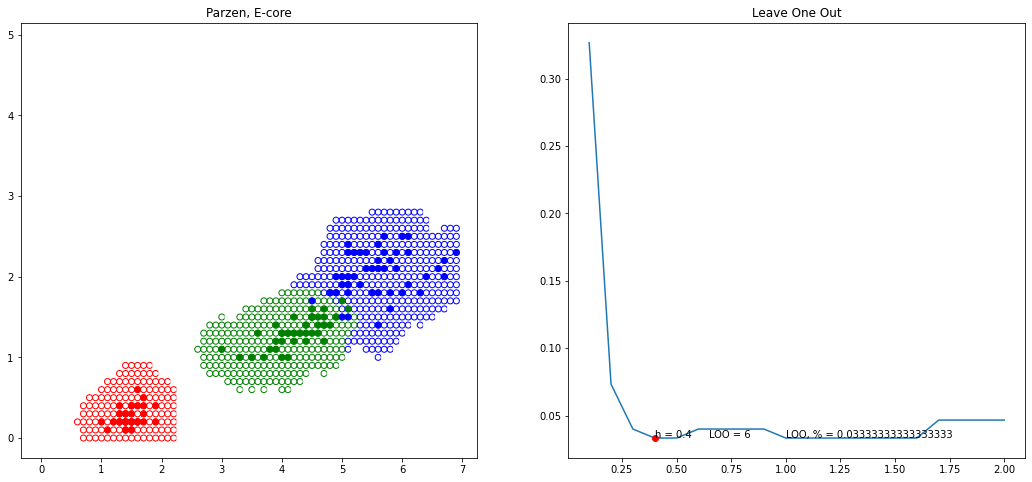

In [ ]:
if __name__ == '__main__':
    main('E')

*Квартическое ядро*

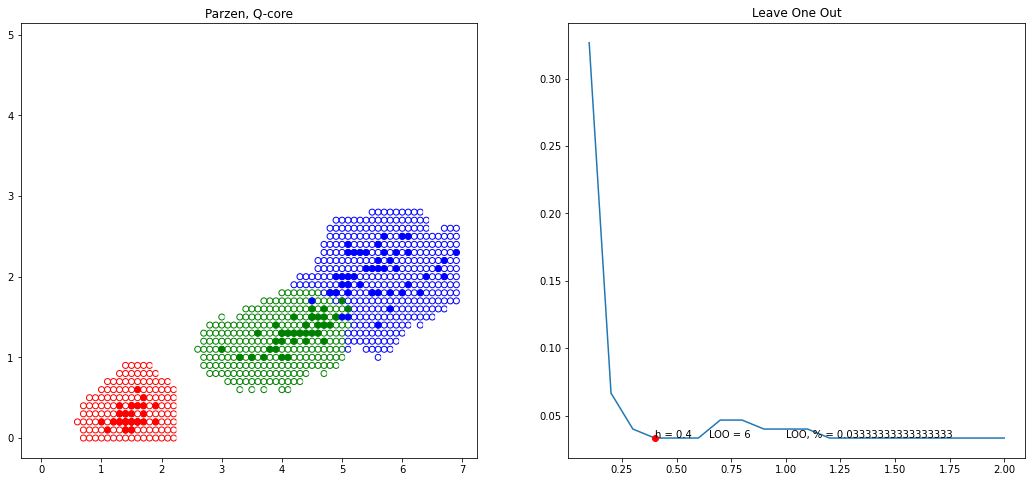

In [ ]:
if __name__ == '__main__':
    main('Q')

*Треугольное ядро*

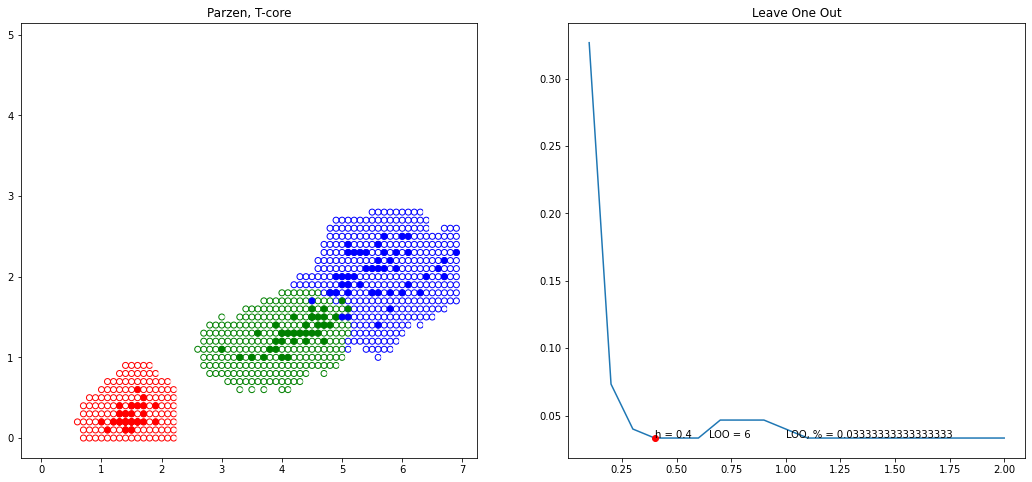

In [ ]:
if __name__ == '__main__':
    main('T')

*Гауссовское ядро*

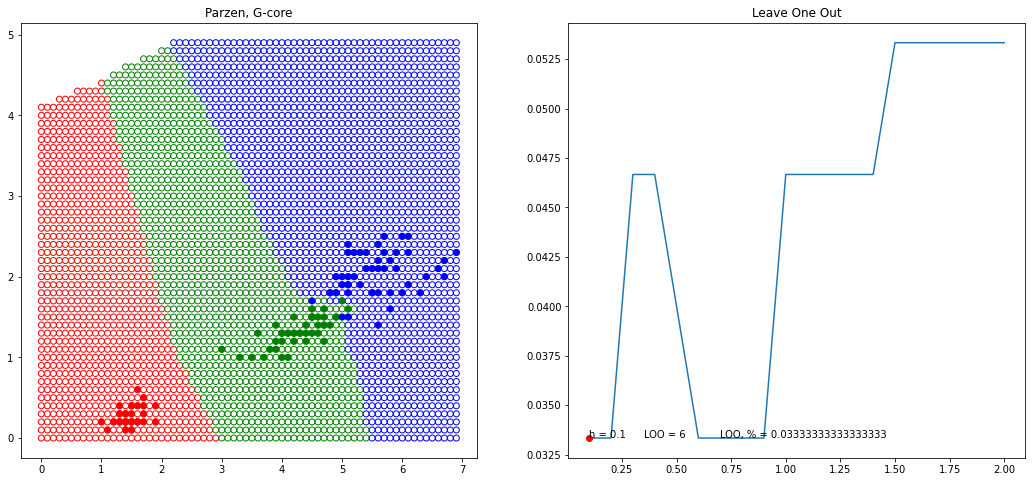

In [ ]:
if __name__ == '__main__':
    main('G')

*Прямоугольное ядро*

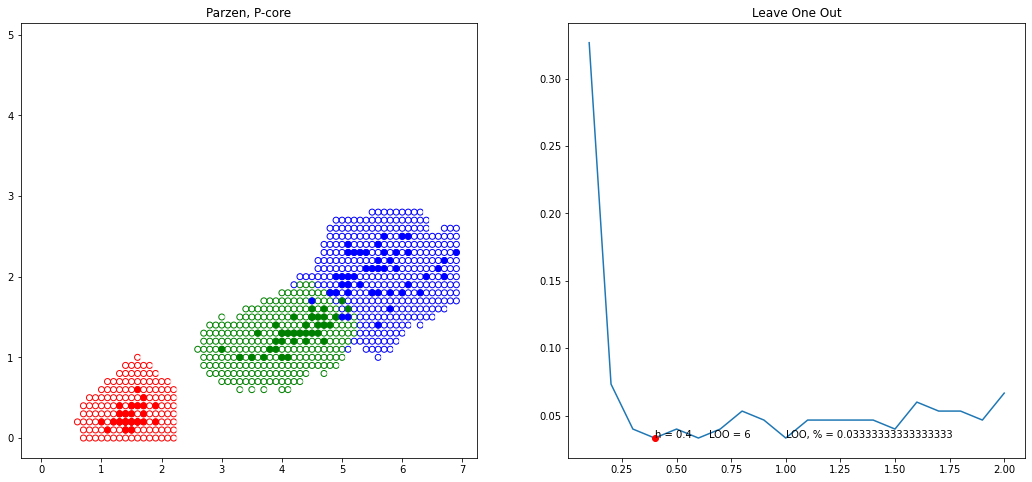

In [ ]:
if __name__ == '__main__':
    main('P')

---
### ***Сводная таблица для алгоритма парзеновского окна***
---

\begin{array}{|c|c|c|}
\hline\bf\text{Тип Ядра}&\text{h}&\text{LOO}&\text{LOO, %}\\
\hline\text{Епанечникова}&\text{0.4}&\text{6}&\text{0.033}\\
\hline\text{Квартическое}&\text{0.4}&\text{6}&\text{0.033}\\
\hline\text{Треугольное}&\text{0.4}&\text{6}&\text{0.033}\\
\hline\text{Гауссовское}&\text{0.1}&\text{6}&\text{0.033}\\
\hline\text{Прямоугольное}&\text{0.4}&\text{6}&\text{0.033}\\\hline
\end{array}

Достоинства алгоритма:

1.   Простота реализации
2.   Хорошее качество классификации при правильно подобранном h
3.   Не требуется сортировка выборки, в отличии от метода ближайших соседей, что существенно ускоряет время классификации
4.   Выбор ядра слабо влияет на качество классификации.

Недостатки алгоритма:

1.   Необходимо хранить выборку целиком
2.   Слишком узкие окна h приводят к неустойчивой классификации; а слишком широкие - к вырождению алгоритма в константу
3.   Если ни один объект выборки не попал в радиус окна h вокруг объекта z, то алгоритм не способен его проклассифицировать. Для обхода этого недостатка используется окно h переменной ширины